# Introduction

(NOTE: This notebook is intended for use with the slides found [here](https://github.com/cropsinsilico/CiS2021-hackathon/blob/main/slides.pdf)).

This is a Jupyter notebook. It allows us to run code (in this case Python) alongside text in different "cells". This cell is a markdown cell that can display text and html, the next cell is a code cell.

In the code cells (prefixed by `In [ ]:`), you can assign variables, perform calculations or call external functions/classes. You can run code cells by selecting the cell (so that a blue or green box appears around it) and then clicking the run button (located at the top of the page) or pressing `Shift+Enter` together. Then a number will appear inside the brackets indicating the order of when the cell was executed. 

Output from the cell will be displayed below it with the `Out[#]:` prefix where the number in the brackets indicates the input cell that generated it.

In [ ]:
x = 1
y = 3
z = (x + y)**3
z

Any Python code can be used, and we can import external packages as well just like in Python scripts. Cells can also use any variables created in any previously executed cell. The cell below imports some tools that will be used in the rest of this notebook.

In [1]:
from yggdrasil import tools  # Tools for displaying syntax highlighted source code in the notebook
from yggdrasil.runner import run  # Tool for running integrations from the notebook

The notebook can also display plots, 3D graphics, and interactive widgets. 

The cell below imports a package `trimesh` for loading and displaying 3D meshes in the notebook. You can drag the image to rotate the object and zoom in/out by scrolling over the image. This type of display will be used in some the examples today to display output.

In [2]:
import trimesh
fname = 'meshes/plants-2.obj'
mesh = trimesh.load_mesh(fname)
mesh.show()

# Integrating Models as Functions

yggdrasil provides interfaces in several languages that can be used to open connections with other models, but in many cases, making a model work in integrations can be done by allowing yggdrasil to wrap a function that executes the model calculations.

For example, the model displayed by the cell below calculates (albeit poorly) the intensity of light for a given day of the year and height from the ground. It is written as a Python function that takes `doy` (day of the year) and `height` as inputs and returns the intensity as output.

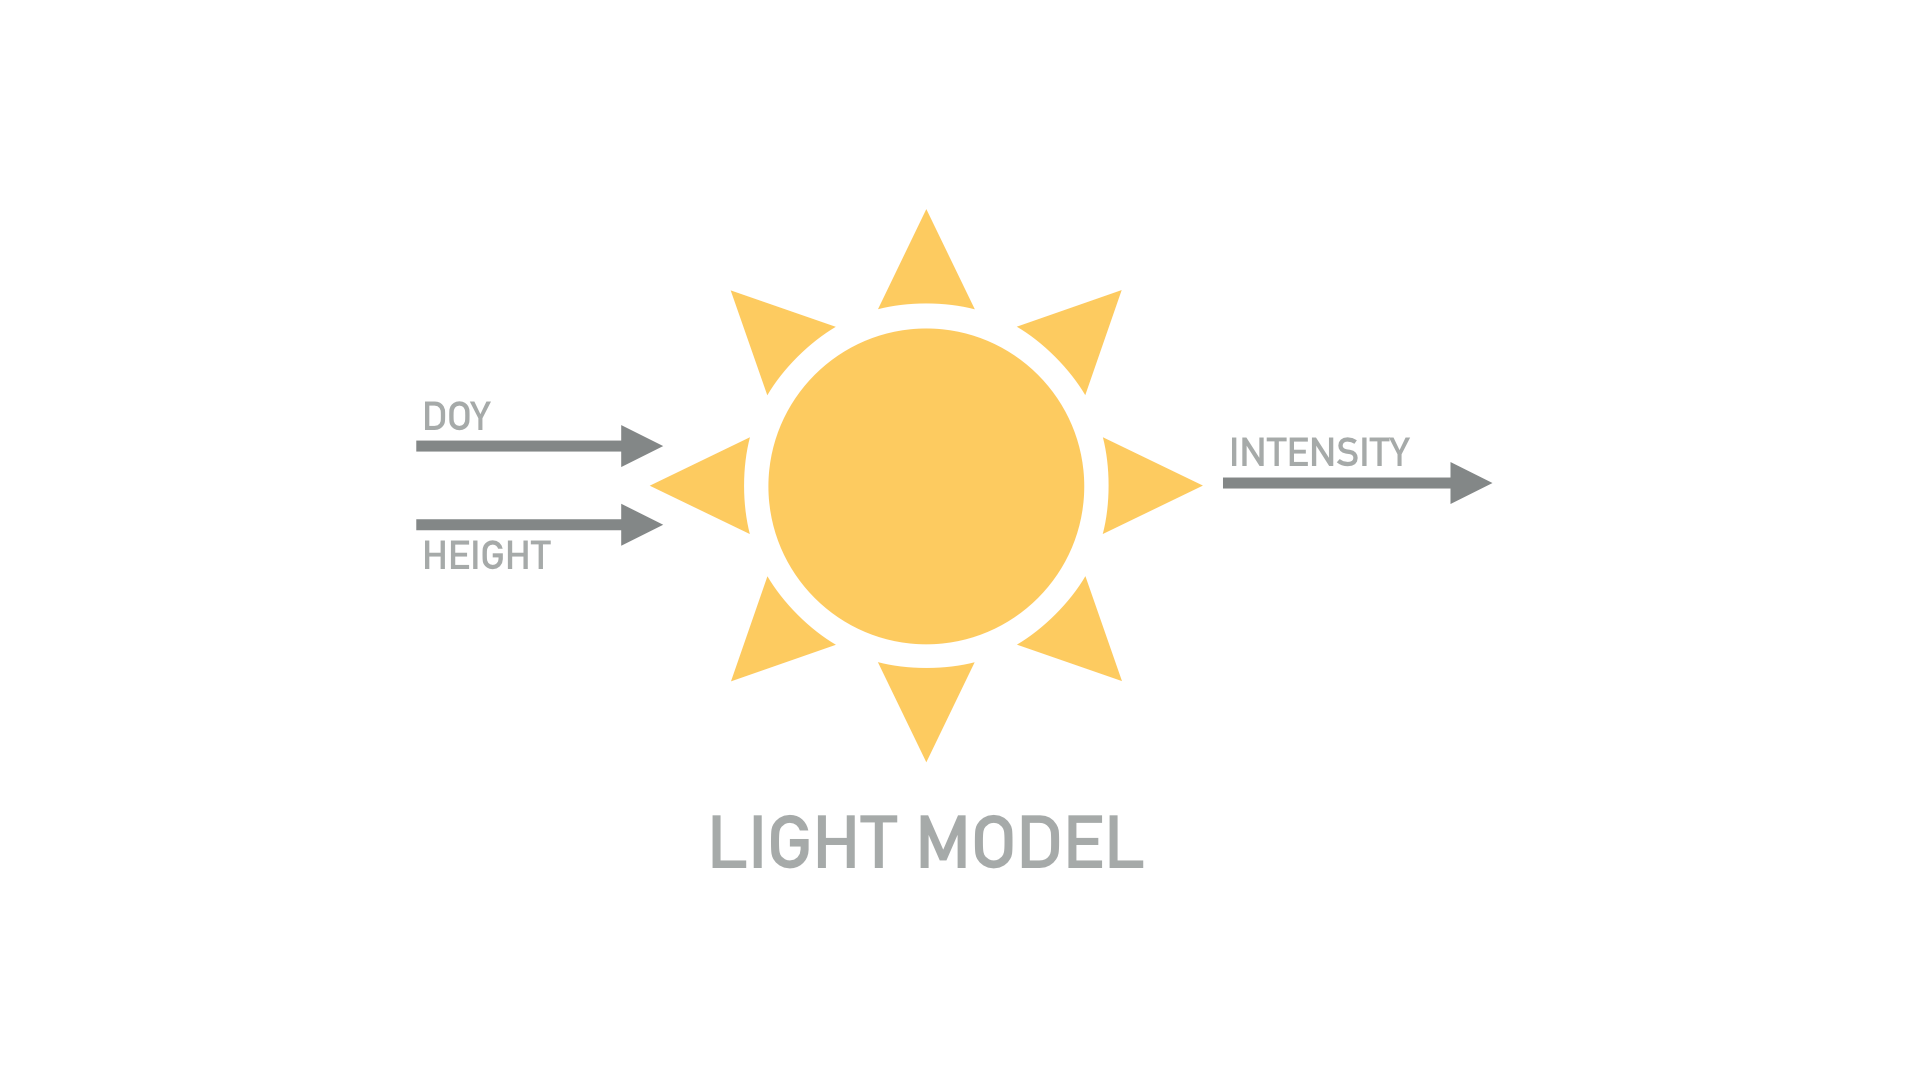

In [ ]:
tools.display_source('models/light_v0.py', number_lines=True)

To use this model with yggdrasil, no modification of the code is necessary. The only new material required is a YAML configuration file. The cell below displays the YAML for the model above.

In [ ]:
tools.display_source('yamls/light_v0_python.yml', number_lines=True)

This alone will not allow yggdrasil to run as the model inputs & output are not connected to anything. The YAML file below declares the connections that should be made to get input from the tab-delimited table `input/light_v0.txt` (also shown below) and direct output to the file `output/light_v0.txt`.

Since the input/output to the light model is not explicitly defined in the model YAML above, yggdrasil assumes that all inputs will come from the same channel named `<model_name>:input` and names the output channel `<model_name>:output`.

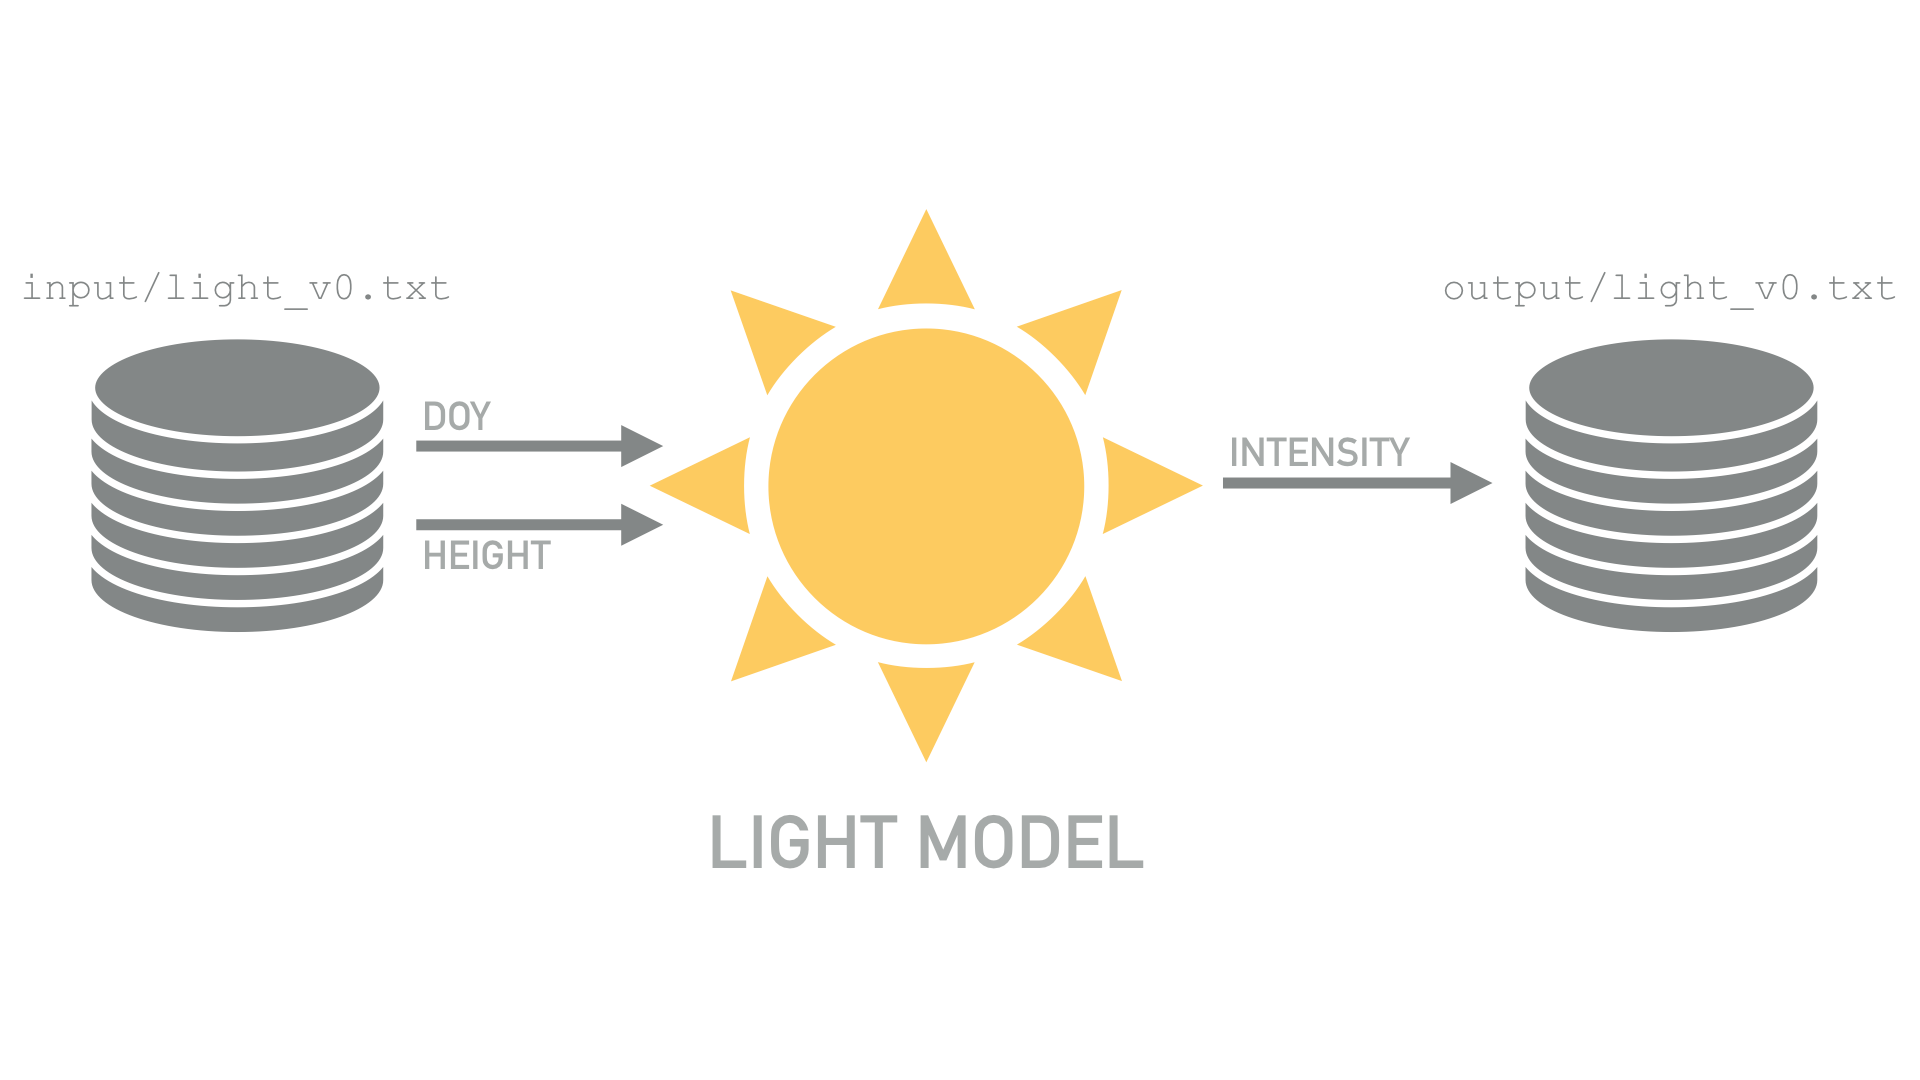

In [ ]:
tools.display_source('yamls/connections_v0.yml', number_lines=True)

To run the light-to-file integration defined in these two YAML files, the `run` function is called with the paths to the YAML files as input. This is equivalent to calling `yggrun yamls/light_v0_python.yml yamls/connections_v0.yml --production-run` from the command line.

The output from the yggdrasil integration will include output from the models themselves, some information about what stage each model is in, and the duration of different stages in the integration take to complete. In the case of running multiple models, the output from different models will often be interwoven and does not necessary indicate the order that models are executed in.

In [ ]:
run(['yamls/light_v0_python.yml', 'yamls/connections_v0.yml'], production_run=True)

The cell below will display the contents of the output file `output/light_v0.txt` following the run.

In [ ]:
tools.display_source('output/light_v0.txt', number_lines=True)

## Command Line Interface
The examples above have been using yggdrasil's Python interface to run the integration, but that is not necessary. yggdrasil has a command line utility for running integration `yggrun` which takes YAML paths as inputs.

## The `production_run` Keyword
You may have noticed that we passed the `production_run` keyword to the `run` API function with a value of `True`. When set to `True`, yggdrasil turns of several safe guards that increase run-time. These include things like checking data formats and validating inputs/outputs to/from framework components. It is highly recommended, that `production_run` is only set to `True` when you are done testing an integration and are ready for a "production run" that requires higher performance. The `production_run` flag can also be passed to the command line interface `yggrun` as `--production-run`.

## Similarly in Other Languages

NOTE: Units must be explicitly added via a `datatype` entry in the model yaml for the compiled languages (i.e. C, C++, & Fortran)

### C++ Version

In [ ]:
tools.display_source('models/light_v0.cpp', number_lines=True)
tools.display_source('yamls/light_v0_cpp.yml', number_lines=True)
run(['yamls/light_v0_cpp.yml', 'yamls/connections_v0.yml'], production_run=True)
tools.display_source('output/light_v0.txt', number_lines=True)

### Fortran Version

In [ ]:
tools.display_source('models/light_v0.f90', number_lines=True)
tools.display_source('yamls/light_v0_fortran.yml', number_lines=True)
run(['yamls/light_v0_fortran.yml', 'yamls/connections_v0.yml'], production_run=True)
tools.display_source('output/light_v0.txt', number_lines=True)

### R Version

In [ ]:
tools.display_source('models/light_v0.R', number_lines=True)
tools.display_source('yamls/light_v0_R.yml', number_lines=True)
run(['yamls/light_v0_R.yml', 'yamls/connections_v0.yml'], production_run=True)
tools.display_source('output/light_v0.txt', number_lines=True)

# Integrating Models via Interface

The function wrapping method of yggdrasil works in many cases, but not all. When a model must send or receive data to/from another model mid-calculation or the model algorithm is written such that writing it as a function would be unwieldy, the yggdrasil interface can be used directly.

For example, the model below simulates growth of a 3D shoot structure over time and is executed via the command line with parameters controlling the how long the simulations runs and what the initial mesh looks like.

In [ ]:
tools.display_source('models/shoot_v0.py', number_lines=True)

We can run this model via the command line or via yggdrasil using the YAML displayed below which runs the model for 48 hrs with a time step of 6 hrs and does not handle any input or output.

In [ ]:
tools.display_source('yamls/shoot_v0.yml', number_lines=True)
run('yamls/shoot_v0.yml', production_run=True)

The final mesh from this simulation is displayed by the cell below using the `trimesh` package.

In [ ]:
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

If we want to determine the light intensity at the top of the plant at each timestep, re-writing this model as a function and allowing yggdrasil to wrap it requres a lot of modification to the original code. Instead we can create an output channel via the yggdrasil Python interface with minimal modification to the code.

The cell below shows the diff for an updated version of this model that does this.
1. Checks if the yggdrasil version of the code should be run
1. Imports the relevant yggdrasil modules and functions and opens an output channel with the name `height`
1. Sends the time and maximum height of the mesh to the `height` output channel with units


In [ ]:
tools.display_source_diff('models/shoot_v0.py', 'models/shoot_v1.py', number_lines=True)

The above model can be run in the exact same manner as the original without yggdrasil. The YAML diff displayed in the cell below shows the changes necessary to connect the `height` output to a table file `output/height.txt` in the absence of any other connection.

In [ ]:
tools.display_source_diff('yamls/shoot_v0.yml', 'yamls/shoot_v1.yml', number_lines=True)

The cell below runs the 1-model integration defined in the YAML above.

In [ ]:
run(['yamls/shoot_v1.yml'], production_run=True)

The resulting mesh and `output/height.txt` file is displayed by the next two cells.

In [ ]:
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

In [ ]:
tools.display_source('output/height.txt')

# Simple input/output

To instead direct the heights to the light model from above, we then use an updated version of the `yamls/connections_v0.yml` YAML (diff displayed below). This can be in same file or a new one as the model, but is separate here to keep output modular.

In [ ]:
tools.display_source_diff('yamls/connections_v0.yml', 'yamls/connections_v1.yml', number_lines=True)

To run this integration, we then pass 3 YAMLs: the light model YAML, the shoot model YAML, and the shoot-to-light connection YAML.

In [ ]:
run(['yamls/light_v0_python.yml', 'yamls/shoot_v1.yml', 'yamls/connections_v1.yml'], production_run=True)

The next two cells display the mesh from the final time step and the contents of the resulting `output/light_v0.txt` file.

In [ ]:
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

In [ ]:
tools.display_source('output/light_v0.txt')

# Remote Procedure Call (RPC)

The previous example achieves the goal of connecting the two models, but it is not particularly powerful in this case given that the same could be received by saving the heights from the shoot to a file that can be read by the light model. However, if we want the shoot model to incorporate the light intensity into the calculation of how fast the shoot should grow, then we need to be able to dynamically access the output from the light model at each time step which cannot be accomplished via files. Instead we need the plant model to call the light model at each timestep via a remote procedure call (RPC). The client model (shoot model) sends requests to the server model (light model) and then receives the response via the `call` method.

The diff displayed by the cell below shows the updated version of the shoot model where
1. The `YggRpcClient` interface function is used instead of `YggOutput`
1. The channel name used to complete the connection is `light_shoot` which comes from the name of the two models (`<server>_<client>`)
1. The time and height are sent to the light model via the `call` method which returns the output from the light model (intensity).
1. The scale factor used to grow the shoot mesh is computed based on the light intensity return by the light model

In [ ]:
tools.display_source_diff('models/shoot_v1.py', 'models/shoot_v2.py', number_lines=True)

To run this integration, two key modification need to be made to the model YAMLs as shown in the diffs below:
1. Add the `is_server: true` parameter to the light model YAML to declare that it is a server
1. Add the `client_of: [light]` parameter to the shoot model YAML to tell yggdrasil that it will be calling the light model server as a client

Since yggdrasil handles the server-client connections, no connection YAML is required.

In [ ]:
tools.display_source_diff('yamls/shoot_v1.yml', 'yamls/shoot_v2.yml', number_lines=True)
tools.display_source_diff('yamls/light_v0_python.yml', 'yamls/light_v1_python.yml', number_lines=True)

The cell below runs the shoot-light RPC integration using these YAML files and displays the resulting mesh.

In [ ]:
run(['yamls/light_v1_python.yml', 'yamls/shoot_v2.yml'], production_run=True)
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

## Splitting Calls
Client (and timesync as we will discuss later) "calls" are really a combination of a send and receive (sending the request and receiving the response). If call's take a long amount of time, we can split the call into its components to take advantage of the parallelism yggdrasil offers. A client (or timesync comm) can call send a request, finish another unrelated task while the server/sync operation takes place, and then call receive to get the response. For example, the `call` to the light model in the previous example could be split between a send and receive call:

In [ ]:
tools.display_source_diff('models/shoot_v2.py', 'models/shoot_v2_split.py', number_lines=True)

In [ ]:
run(['yamls/light_v1_python.yml', 'yamls/shoot_v2_split.yml'], production_run=True)
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.show()

# Duplicating Models

Splitting calls can be particularly powerful if you are making many calls to a server model and the server model evaluation does not depend on previous calls. In such cases, multiple copies of the server model can be run in parallel and respond to requests in parallel.

The diff displayed in cell below modifies the `models/shoot_v2_split.py` version of the shoot model so that it calculates an intensity for every vertex in the shoot mesh and saves the intensity array to a file as a Python pickle. Requests are sent for every vertex before beginning to receive any responses.

In [ ]:
tools.display_source_diff('models/shoot_v2_split.py', 'models/shoot_v2_copies.py', number_lines=True)

To run 2 copies of the light model, the `copies: 2` line can be added to the light YAML from above as shown in the diff the cell below displays.

In [ ]:
tools.display_source_diff('yamls/light_v1_python.yml', 'yamls/light_v2_python.yml', number_lines=True)

To run this integration, you would pass 2 YAMLS to yggdrasil:
1. The plant model YAML with that outputs heights for every vertex
1. The light model YAML with the `server` and `copies` parameters

The next shell runs this integration and displays the resulting mesh.

In [15]:
run(['yamls/light_v1_python.yml', 'yamls/shoot_v2_copies.yml'], production_run=True)

# Plot results w/ light intensity mapped to color
import pickle
with open('output/light_008.pkl', 'rb') as fd:
    light = pickle.load(fd)
mesh = trimesh.load_mesh('output/mesh_008.obj')
mesh.visual.vertex_colors = trimesh.visual.interpolate(light/max(light))
mesh.show()

## Parallelism inside MyBinder
Unless you install the materials locally, your notebook is being hosted by the MyBinder service. Although yggdrasil attempts to run the models in parallel, there is essentially only 1 core available on the instances provided (for free) by MyBinder so integrations run on MyBinder instances are not really running in parallel (they are running concurrently so one can run while the other is waiting for an asynchronous call to return, but the models must share the CPU). If you were to download the demo repository and run the notebook on your machine, you would see much better performance from all of the integrations involving more than one model as they would actually run in parallel.